In [1]:
import torch

In [2]:
def differentiable_histogram(x, weights=None, bins=50, min=0.0, max=1.0):
        if x.dim() != 1:
            raise ValueError('Input tensor must be 1-dimensional.')

        if min is None:
            min = x.min().item()
        if max is None:
            max = x.max().item()

        if weights is None:
            weights = torch.ones_like(x)
        elif weights.shape != x.shape:
            raise ValueError('Weights must have the same shape as the input tensor.')

        delta = (max - min) / bins
        bin_edges = torch.linspace(min, max, bins + 1, device=x.device)
        centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        x = x.unsqueeze(1)  # Shape: (n_elements, 1)
        weights = weights.unsqueeze(1)  # Shape: (n_elements, 1)

        # Compute distances to bin centers
        diff = x - centers

        # Compute weights for each bin
        weight_left = torch.nn.functional.relu(1 - torch.abs(diff) / delta)
        weight_right = torch.nn.functional.relu(1 - torch.abs(diff - delta) / delta)

        # Combine weights and compute histogram
        hist = torch.sum(weights * (weight_left + weight_right), dim=0)

        return hist / delta, bin_edges

NumPy histogram total count: 1643
Differentiable histogram total count: 3332.9404296875


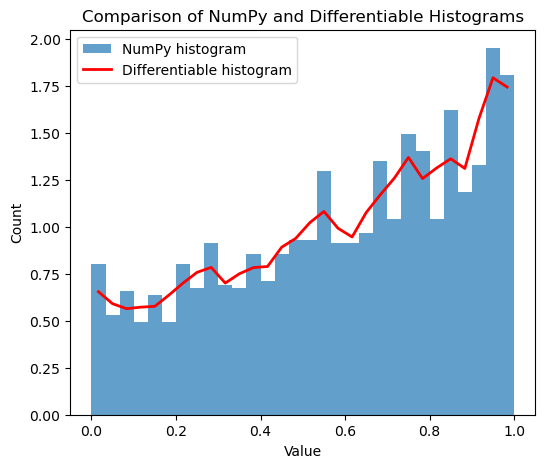

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# Generate some random data
np.random.seed(42)  # for reproducibility
data = np.random.normal(loc=5, scale=2, size=100000)
x = torch.tensor(data, dtype=torch.float32)

# Compute the histogram
hist, bin_edges = differentiable_histogram(x, bins=30)

# Convert to numpy for plotting
hist_np = hist.numpy()
bin_edges_np = bin_edges.numpy()

# Compute NumPy histogram
np_hist, _ = np.histogram(data, bins=bin_edges_np)

# Create the plot
plt.figure(figsize=(6,5))
plt.hist(data, bins=bin_edges_np, density = True,alpha=0.7, label='NumPy histogram')
#plt.plot((bin_edges_np[:-1] + bin_edges_np[1:]) / 2, hist_np, 'r-', linewidth=2, label='Differentiable histogram')
plt.plot((bin_edges_np[:-1] + bin_edges_np[1:]) / 2, hist_np / hist_np.sum() / np.diff(bin_edges_np), 'r-', linewidth=2, label='Differentiable histogram')
plt.xlabel('Value')
plt.ylabel('Count')
plt.title('Comparison of NumPy and Differentiable Histograms')
plt.legend()

# Print total counts for comparison
print(f"NumPy histogram total count: {np_hist.sum()}")
print(f"Differentiable histogram total count: {hist_np.sum() * np.diff(bin_edges_np)[0]}")

plt.show()